Deleted existing tumor_data.csv
Saved data to tumor_data.csv
Epoch 0, Loss: 5959.6728515625, Validation Loss: 7809.81640625
Epoch 500, Loss: 14.55489730834961, Validation Loss: 16.83552360534668
Epoch 1000, Loss: 0.11776770651340485, Validation Loss: 0.09041387587785721
Epoch 1500, Loss: 0.03756975010037422, Validation Loss: 0.0330696739256382
Epoch 2000, Loss: 0.028033966198563576, Validation Loss: 0.028340784832835197
Epoch 2500, Loss: 0.005189129151403904, Validation Loss: 0.006717291194945574


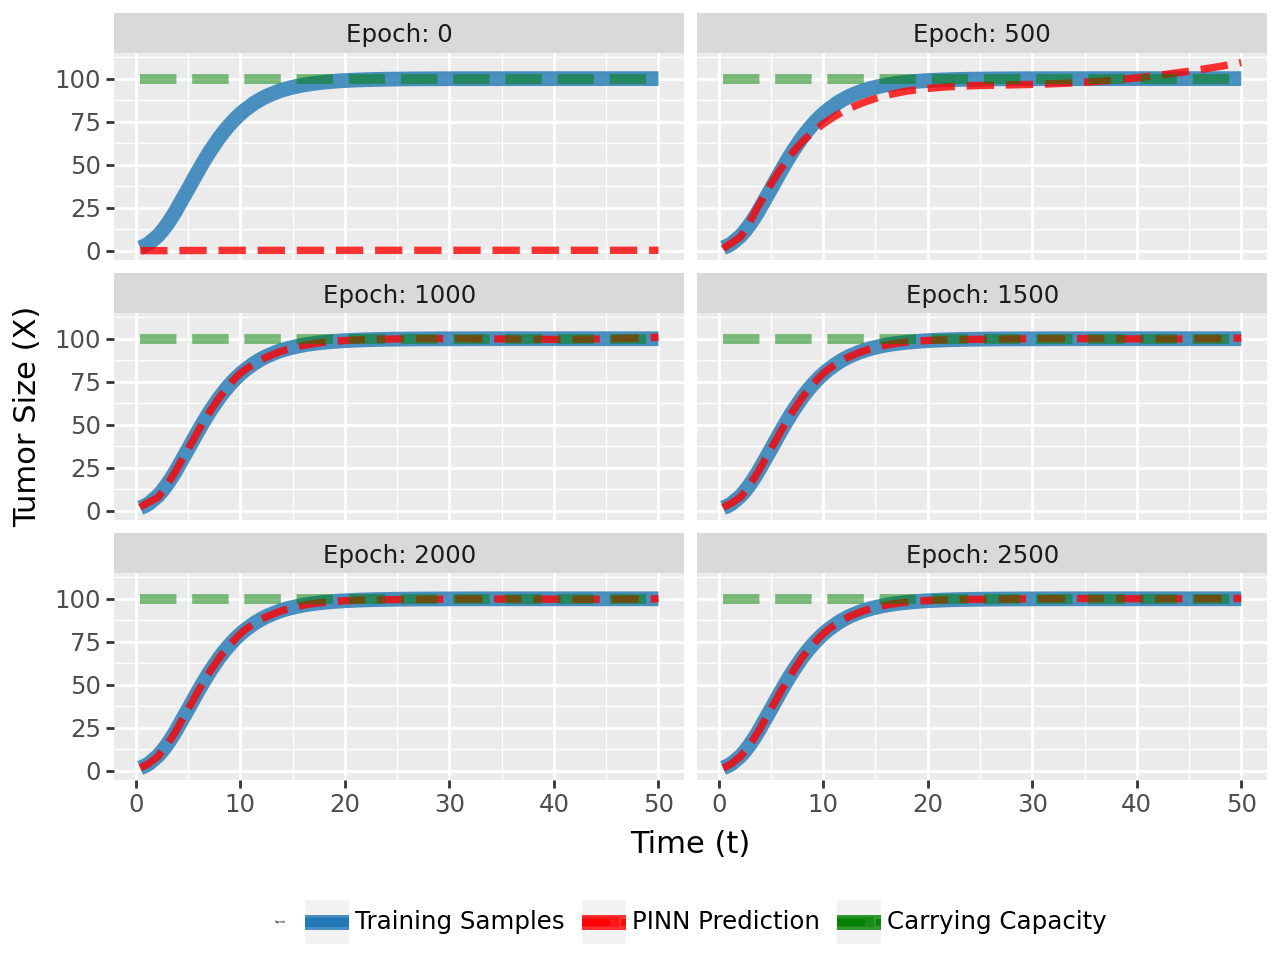

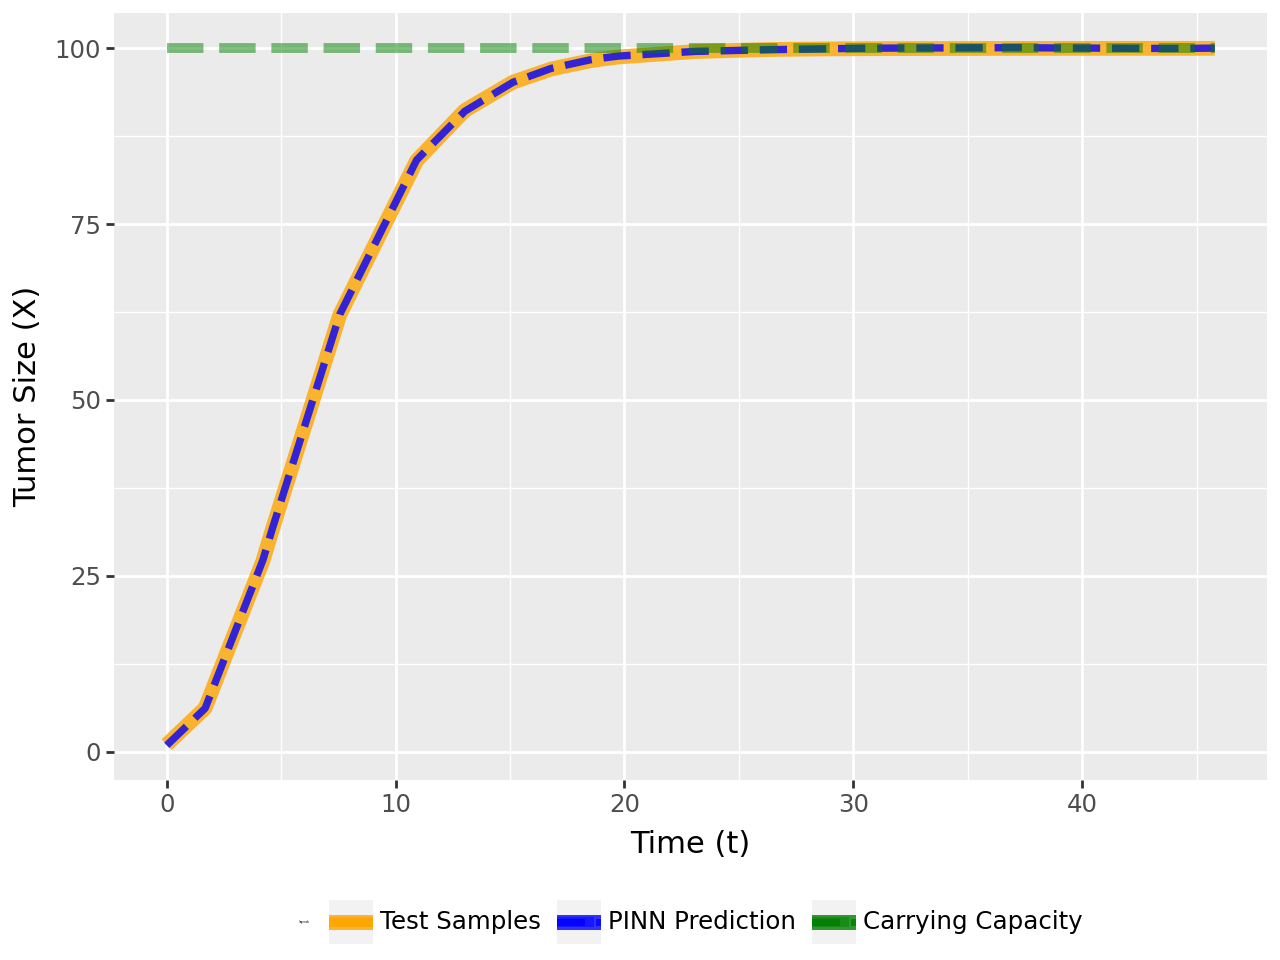

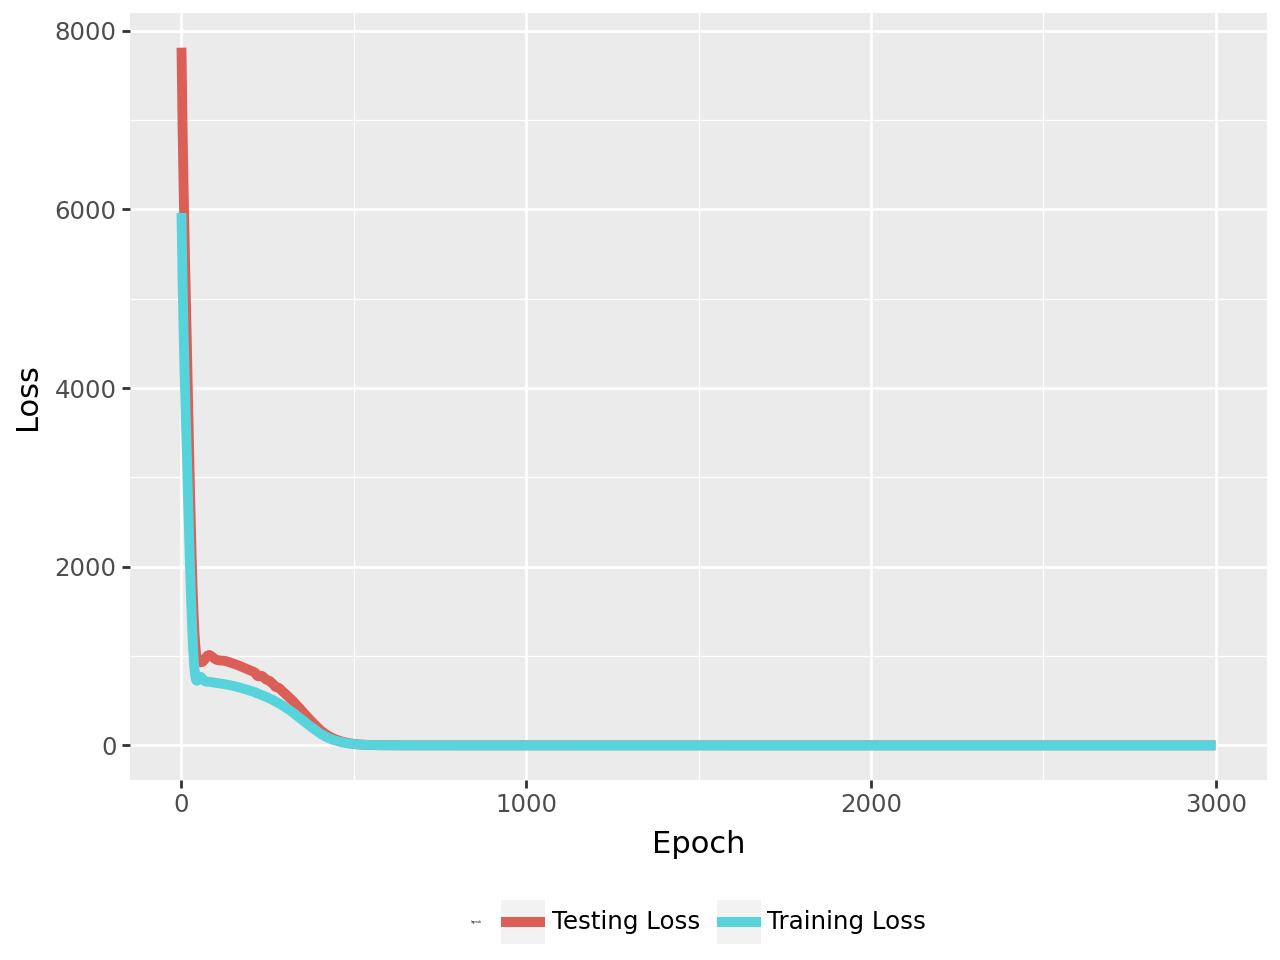

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from data_generation import simulate_data
from data_preparation import load_and_prepare_data
from pinn_model import PINN, physics_loss_fn
from training import train_with_physics_loss
from utils import prepare_dataloader, to_tensor
from ode import ode_func  
from TG_plot_utils import *



import warnings
warnings.filterwarnings("ignore")


def main():
    ############################ Configuration Section ############################

    # Define paths and parameters
    output_file = 'tumor_data.csv'
    if os.path.exists(output_file):
        os.remove(output_file)
        print('Deleted existing tumor_data.csv')

    # Define ODE parameters
    PARAMS = (0.3, 100)  # [alpha, K]
    T = 50  # Time range for simulation
    NUM_SAMPLES = 120  # Number of data points
    Y0 = [1]  # Initial condition

    # Neural Network Configuration
    INPUT_DIM = 1
    HIDDEN_DIMS = [100, 100]  # List of hidden layer sizes
    OUTPUT_DIM = 1
    ACTIVATION_FN = [nn.Sigmoid, nn.Tanh, nn.ReLU, nn.LeakyReLU, nn.ELU, nn.SELU, nn.Softmax, nn.LogSoftmax, nn.GELU ]
    ACTIVATION_FN = ACTIVATION_FN[8]

    # Hyperparameters
    BATCH_SIZE = 32
    LR = 0.001  # Learning rate
    EPOCHS = 3000
    PATIENCE = 200  # Patience for early stopping

    ############################ Simulate Data ############################

    simulate_data(ode_func, PARAMS, T, NUM_SAMPLES, Y0, output_file)

    ############################ Load and Prepare Data ############################

    t_train_set, t_test_set, data_X_train_set, data_X_test_set = load_and_prepare_data(output_file)

    # Convert data to tensors
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader = prepare_dataloader(t_train_set, data_X_train_set, BATCH_SIZE, device)
    t_train_tensor = to_tensor(t_train_set, device, requires_grad=True)
    data_X_train_tensor = to_tensor(data_X_train_set, device)
    t_test_tensor = to_tensor(t_test_set, device, requires_grad=True)
    data_X_test_tensor = to_tensor(data_X_test_set, device)

    ############################ Define and Train Model ############################

    model = PINN(INPUT_DIM, HIDDEN_DIMS, OUTPUT_DIM, ACTIVATION_FN).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    history, train_losses, val_losses = train_with_physics_loss(
        model, optimizer, EPOCHS, PATIENCE, t_train_tensor, data_X_train_tensor, t_test_tensor, data_X_test_tensor, physics_loss_fn, PARAMS
    )

    ############################ Plot Results ############################

    x_ticks = np.linspace(0, T, num=6)
    y_ticks = np.linspace(0, PARAMS[1], num=5)
    epochs_to_plot = [i for i in range(0, EPOCHS, 500) if i in history]
    
    if epochs_to_plot:
        plot_training_results(t_train_set, data_X_train_set, history, epochs_list=epochs_to_plot, K=PARAMS[1], x_ticks=x_ticks, y_ticks=y_ticks)
        plot_testing_results1(t_test_set, data_X_test_set, history, epochs_list=epochs_to_plot, K=PARAMS[1], x_ticks=x_ticks, y_ticks=y_ticks)
        plot_loss_curves(train_losses, val_losses)

if __name__ == '__main__':
    main()


Epoch 500/1500, Loss: 2406.2791, alpha: 0.3001, K: 99.9993
Epoch 1000/1500, Loss: 1.4496, alpha: 0.3001, K: 99.9993
Epoch 1500/1500, Loss: 0.9373, alpha: 0.3001, K: 99.9993


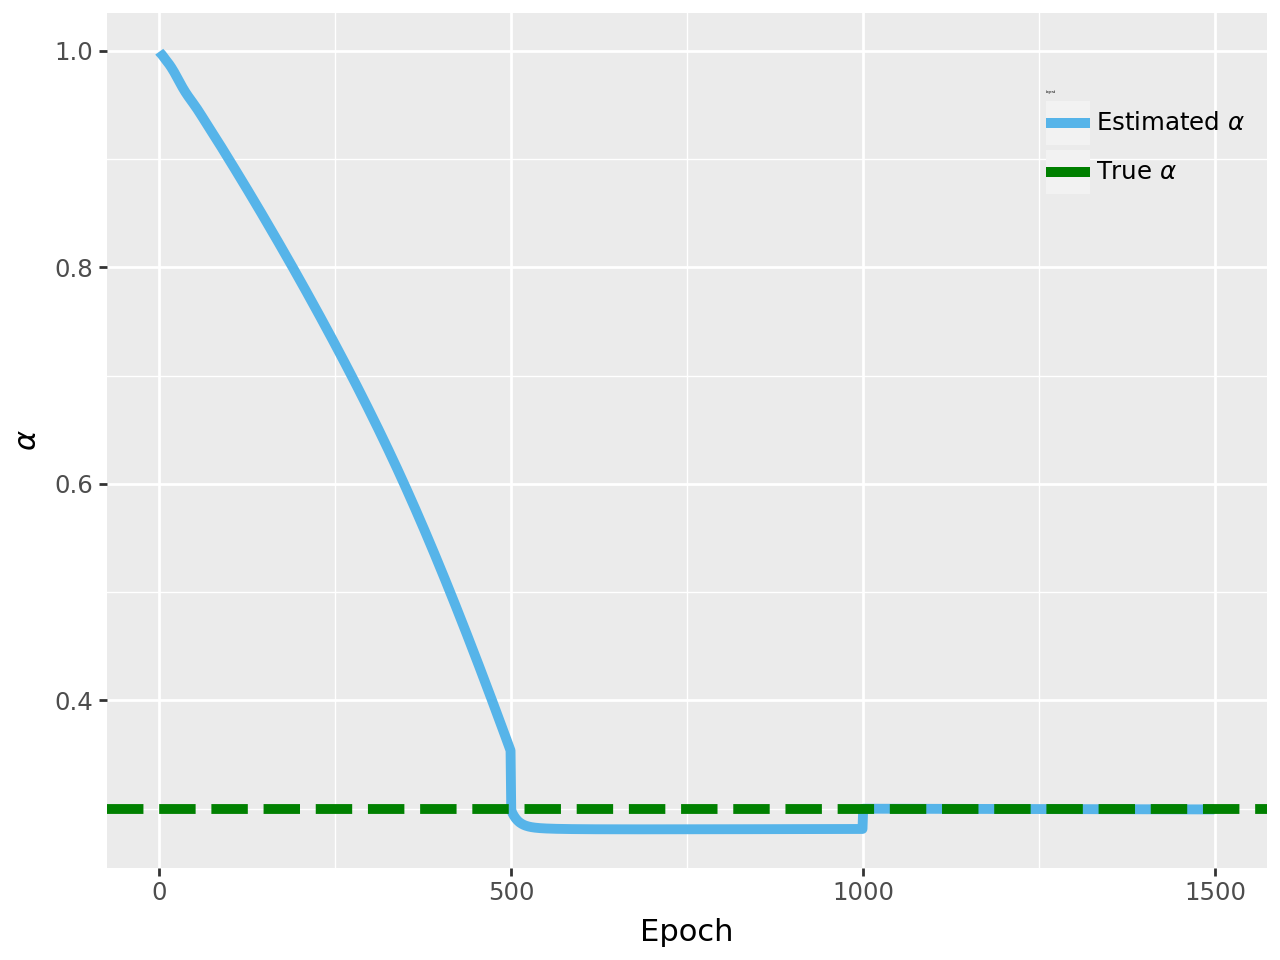

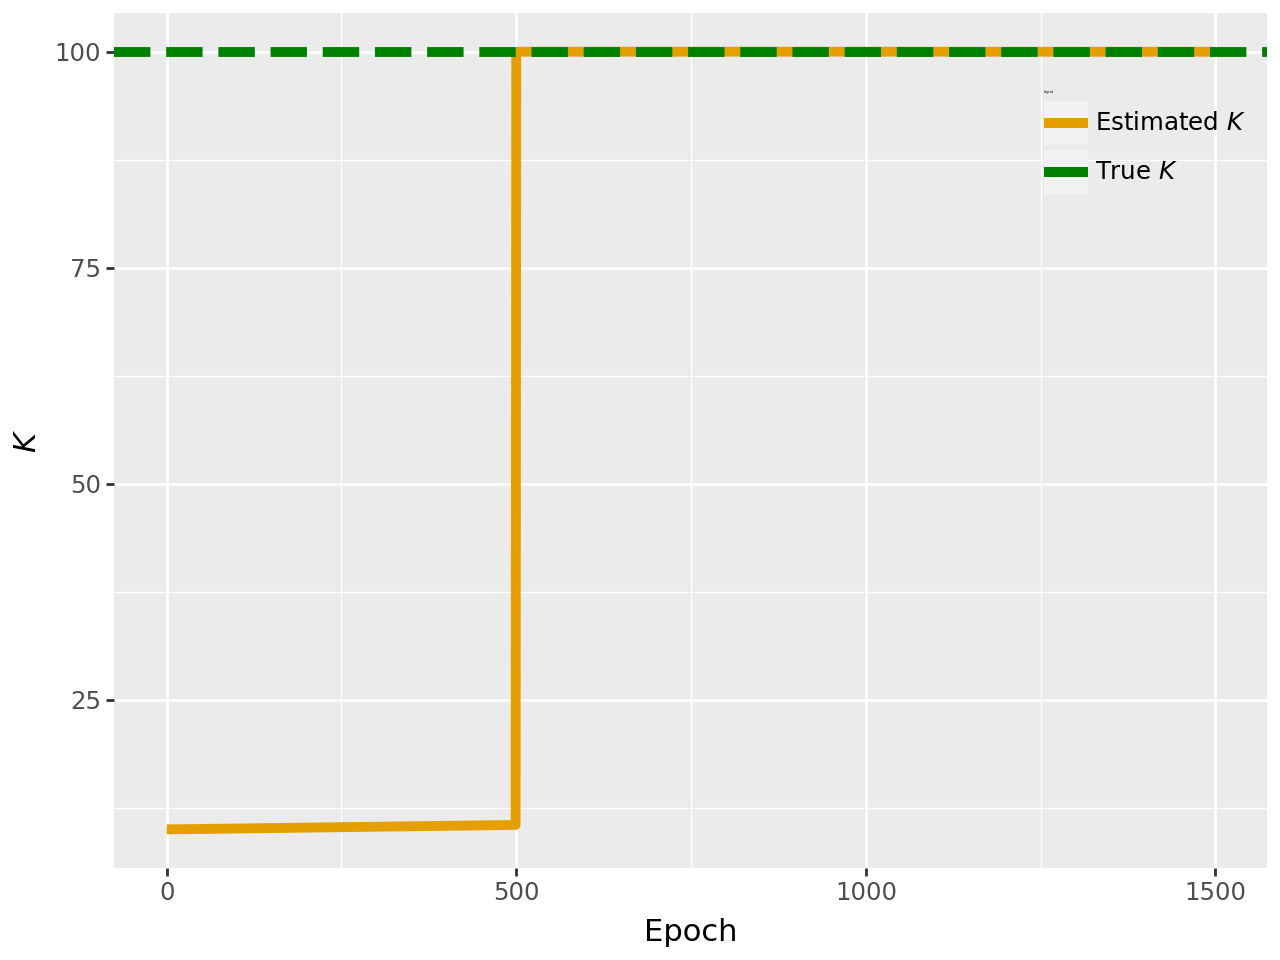

In [3]:
import torch
from utils_IP import load_data
from model_IP import PopulationPINN
from training_IP import train_model
from TG_plot_utils import *
import numpy as np


import warnings
warnings.filterwarnings("ignore")


def main():
    # Configuration Section
    INPUT_DIM = 1
    LR = 0.001  # Learning rate
    EPOCHS = 1500
    EPOCH_INTERVAL = 500  # Interval for plotting and printing
    PATIENCE = 200  # Patience for early stopping

    filename = "tumor_data.csv"
    timepoints, population = load_data(filename)

    true_alpha = 0.3
    true_K = 100

    # Initialize the model with estimated parameters
    params0 = np.array([1.0, 10.0])
    alpha_init, K_init = params0[0], params0[1]

    # Create and train the PINN model with initial guesses
    model = PopulationPINN(input_dim=INPUT_DIM, alpha_init=alpha_init, K_init=K_init)
    model, alpha_history, K_history, loss_history = train_model(model, timepoints, population, num_epochs=EPOCHS, EPOCH_INTERVAL=EPOCH_INTERVAL, lr=LR)

    # Generate predictions with the trained PINN
    t_dense = np.linspace(timepoints[0], timepoints[-1], num=1000)
    t_dense_tensor = torch.tensor(t_dense, dtype=torch.float32).view(-1, 1)
    solution = model.forward(t_dense_tensor).detach().numpy()

    # Plot results and parameter evolution
    plot_parameters(alpha_history, K_history, true_alpha, true_K)

if __name__ == "__main__":
    main()
